In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    #     # 자산별 비중이 반영된 개별자산 누적 수익률
    #     weightedCumulativeReturn = weight * cumulativeReturn
    #     # 자산흐름 정규화: 시기별 각 자산 보유 비율
    #     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
    #     # 자산별 비중이 반영된 개별자산 일별 수익률
    #     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
    #     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
    #     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
    #     # 포트폴리오 누적 수익률
    #     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
    # #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

--------------------------------------------------
# 채권 혼합

In [4]:
# 코스피 ETF 채권 ETF 1:1 혼합

# 데이터 로드
kodex200 = getCloseData("069500", "2000") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2000") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True) # 데이터가 존재하지않는 일자가#  있을경우 드랍
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21149,49960.0
2012-01-25,21222,49960.0
2012-01-26,21243,49930.0
2012-01-27,21276,50000.0
2012-01-30,21036,50130.0
...,...,...
2024-03-18,36520,65610.0
2024-03-19,36085,65415.0
2024-03-20,36720,65480.0


In [5]:
# 결측치 가볍게 검사
pd.isnull(closeDataSet).sum()

kodex200       0
kodex10Bond    0
dtype: int64

----------------------------------------------------------
**주식과 채권의 움직임 비교**

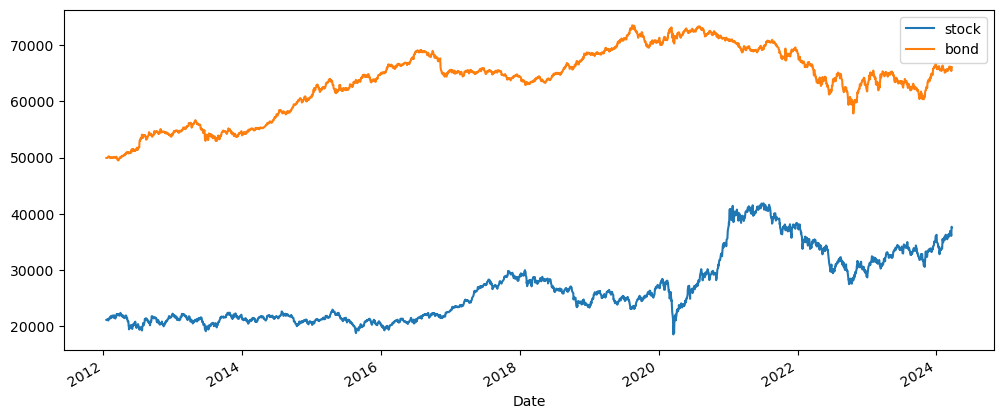

In [6]:
plt.figure(figsize=(12, 5))
closeDataSet['kodex200'].plot(label="stock")
closeDataSet['kodex10Bond'].plot(label="bond")
plt.legend()
plt.show()

가격 수준이 달라 정규화
정규화 = $ \frac{주가 - 주가 평균}{주가 표준편차} $

In [7]:
# 데이터 정규화
normalizedCloseDataSet = (closeDataSet - closeDataSet.mean()) / closeDataSet.std()

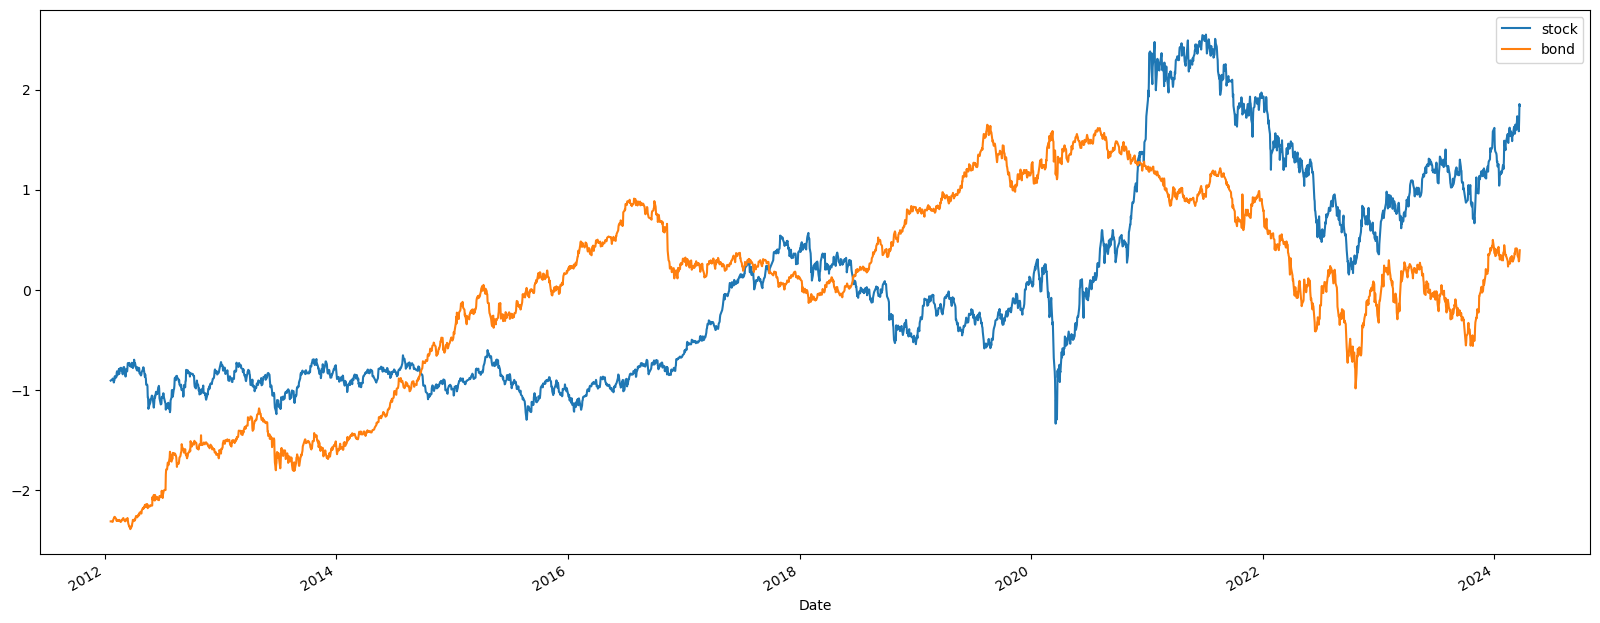

In [8]:
# 정규화 가격 시각화
plt.figure(figsize=(20, 8))
normalizedCloseDataSet['kodex200'].plot(label="stock")
normalizedCloseDataSet['kodex10Bond'].plot(label="bond")
plt.legend()
plt.show()

### 주식 ETF 성과

In [9]:
kodex200DayReturn = getDayReturn(closeDataSet['kodex200'])
kodex200CumReturn = getCumulativeReturn(closeDataSet['kodex200'])

kodex200Cagr, kodex200Dd, kodex200Mdd = getEvaluation(kodex200CumReturn)

최종 수익률: 1.7780982552366542
cagr: 1.0496011936001801
mdd: 38.08507801040139


In [10]:
kodex200CumReturn

Date
2012-01-20    1.000000
2012-01-25    1.003452
2012-01-26    1.004445
2012-01-27    1.006005
2012-01-30    0.994657
                ...   
2024-03-18    1.726796
2024-03-19    1.706227
2024-03-20    1.736252
2024-03-21    1.783299
2024-03-22    1.778098
Name: kodex200, Length: 2996, dtype: float64

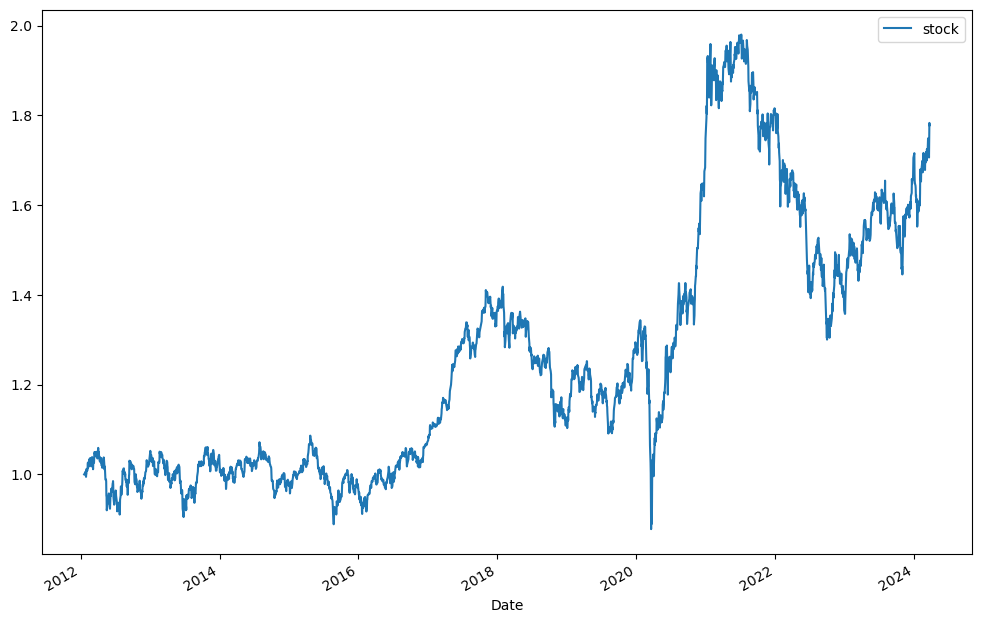

In [11]:
plt.figure(figsize=(12, 8))
kodex200CumReturn.plot(label="stock")
plt.legend()
plt.show()

연평균 수익률이 4.7%이면 나쁘지 않을 수 있지만, MDD가 약 38%입니다.
결코 낮지 않은 수치입니다.

## 채권 ETF와 1:1 혼합할 때 성과

In [13]:
# 지난번 구현해둔 함수를 사용해서 간편하게 구할 수 있음
portDayReturn, portCumReturn = getPortfolioResult(closeDataSet)

In [14]:
portCumReturn

Date
2012-01-20    1.000000
2012-01-25    1.001726
2012-01-26    1.001922
2012-01-27    1.003403
2012-01-30    0.999030
                ...   
2024-03-18    1.520023
2024-03-19    1.507787
2024-03-20    1.523450
2024-03-21    1.549876
2024-03-22    1.550378
Length: 2996, dtype: float64

In [15]:
# 투자 성과 cagr, dd, mdd
print("주식: 채권 1:1 10년 최종수익률")
print(portCumReturn.iloc[-1])
portCagr, portDd, portMdd = getEvaluation(portCumReturn)

주식: 채권 1:1 10년 최종수익률
1.5503781908689276
최종 수익률: 1.5503781908689276
cagr: 1.0375717056869442
mdd: 26.391372070232922


### 시각화

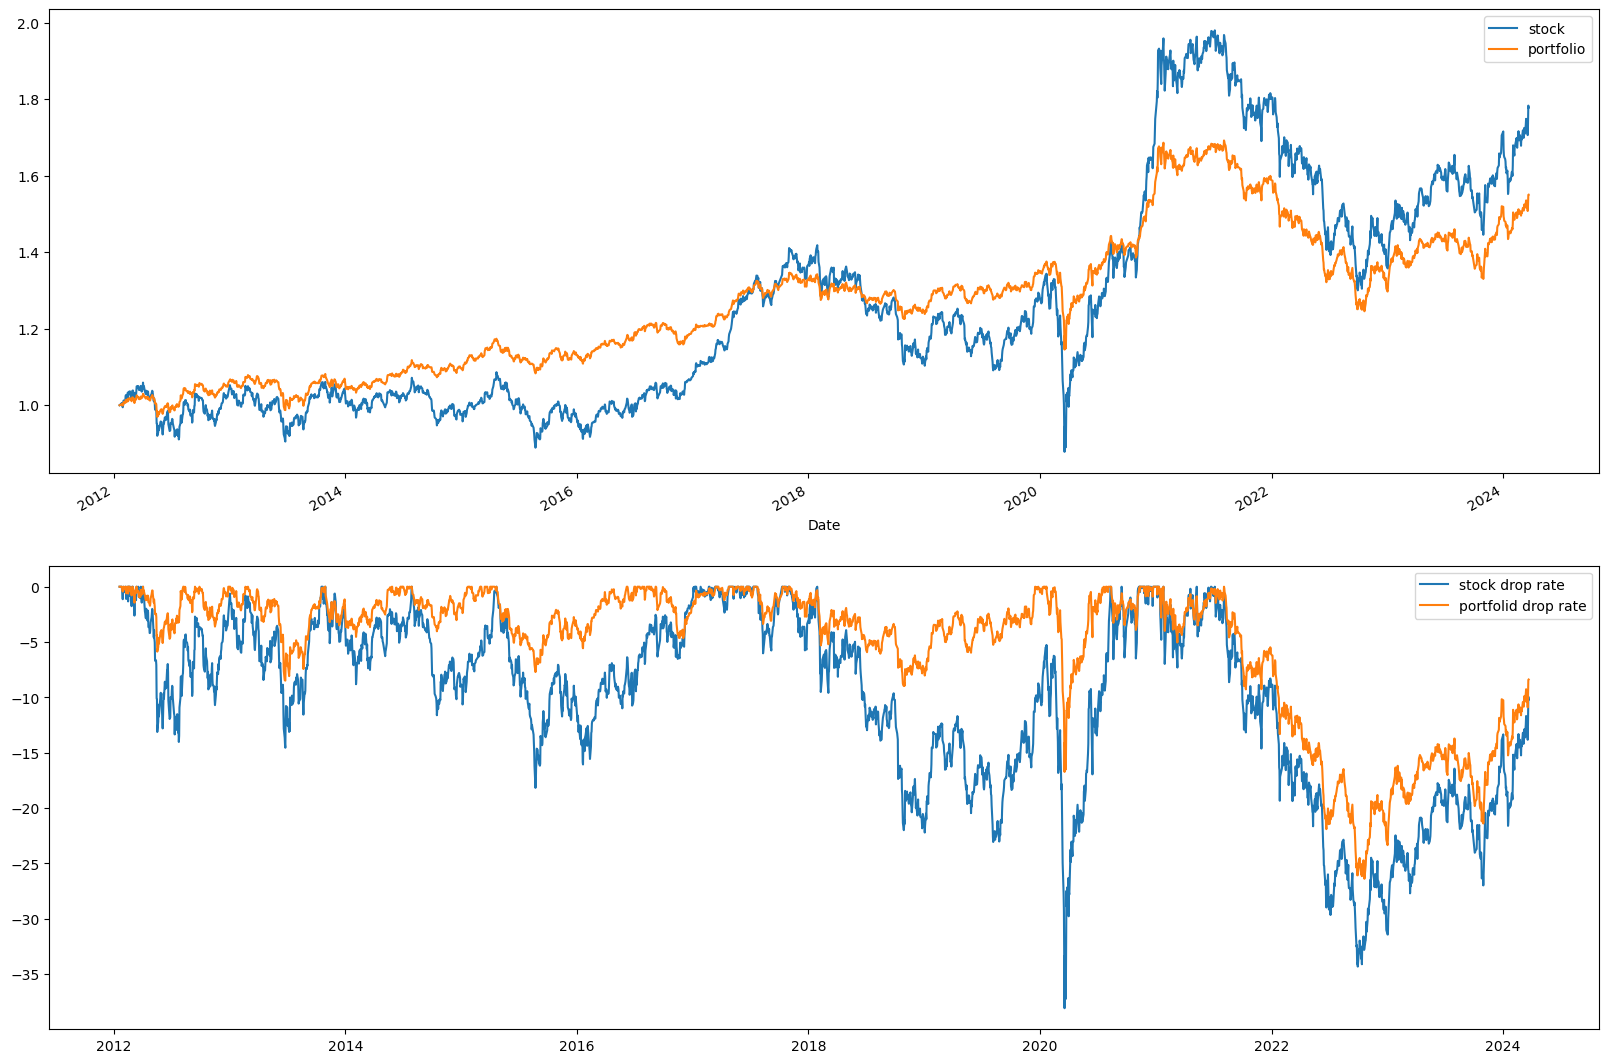

In [16]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd * -1, label="portfolid drop rate")
plt.legend()

plt.show()

코스피200 ETF에만 투자했을 땐 MDD가 38%에 달했지만
채권 ETF를 혼합했을 땐 MDD가 16.7%로 약 20% 이상 감소하여 효과적으로 리스크를 관리했습니다.

## 주식 현금 1:1 혼합

In [17]:
kodex200

Date
2002-10-14     5248
2002-10-15     5377
2002-10-16     5400
2002-10-17     5476
2002-10-18     5711
              ...  
2024-03-18    36520
2024-03-19    36085
2024-03-20    36720
2024-03-21    37715
2024-03-22    37605
Name: Close, Length: 5302, dtype: int64

In [18]:
closeDataSet2 = pd.DataFrame(kodex200)
closeDataSet2.columns = ['kodex200']
closeDataSet2.loc[:, 'cash'] = 1
closeDataSet2 = closeDataSet2.loc['2012-01-20':]
closeDataSet2

,kodex200,cash
Date,,
2012-01-20,21149,1
2012-01-25,21222,1
2012-01-26,21243,1
2012-01-27,21276,1
2012-01-30,21036,1
...,...,...
2024-03-18,36520,1
2024-03-19,36085,1
2024-03-20,36720,1


In [19]:
# 주식 현금 포트폴리오 성과
portDayReturn2, portCumReturn2 = getPortfolioResult(closeDataSet2)
print("주식:현금 1:1 혼합 포트폴리오 최종수익률")
print(portCumReturn2.iloc[-1])
portCagr2, portDd2, portMdd2 = getEvaluation(portCumReturn2)

주식:현금 1:1 혼합 포트폴리오 최종수익률
1.389049127618327
최종 수익률: 1.389049127618327
cagr: 1.0280264402818657
mdd: 22.80646082569098


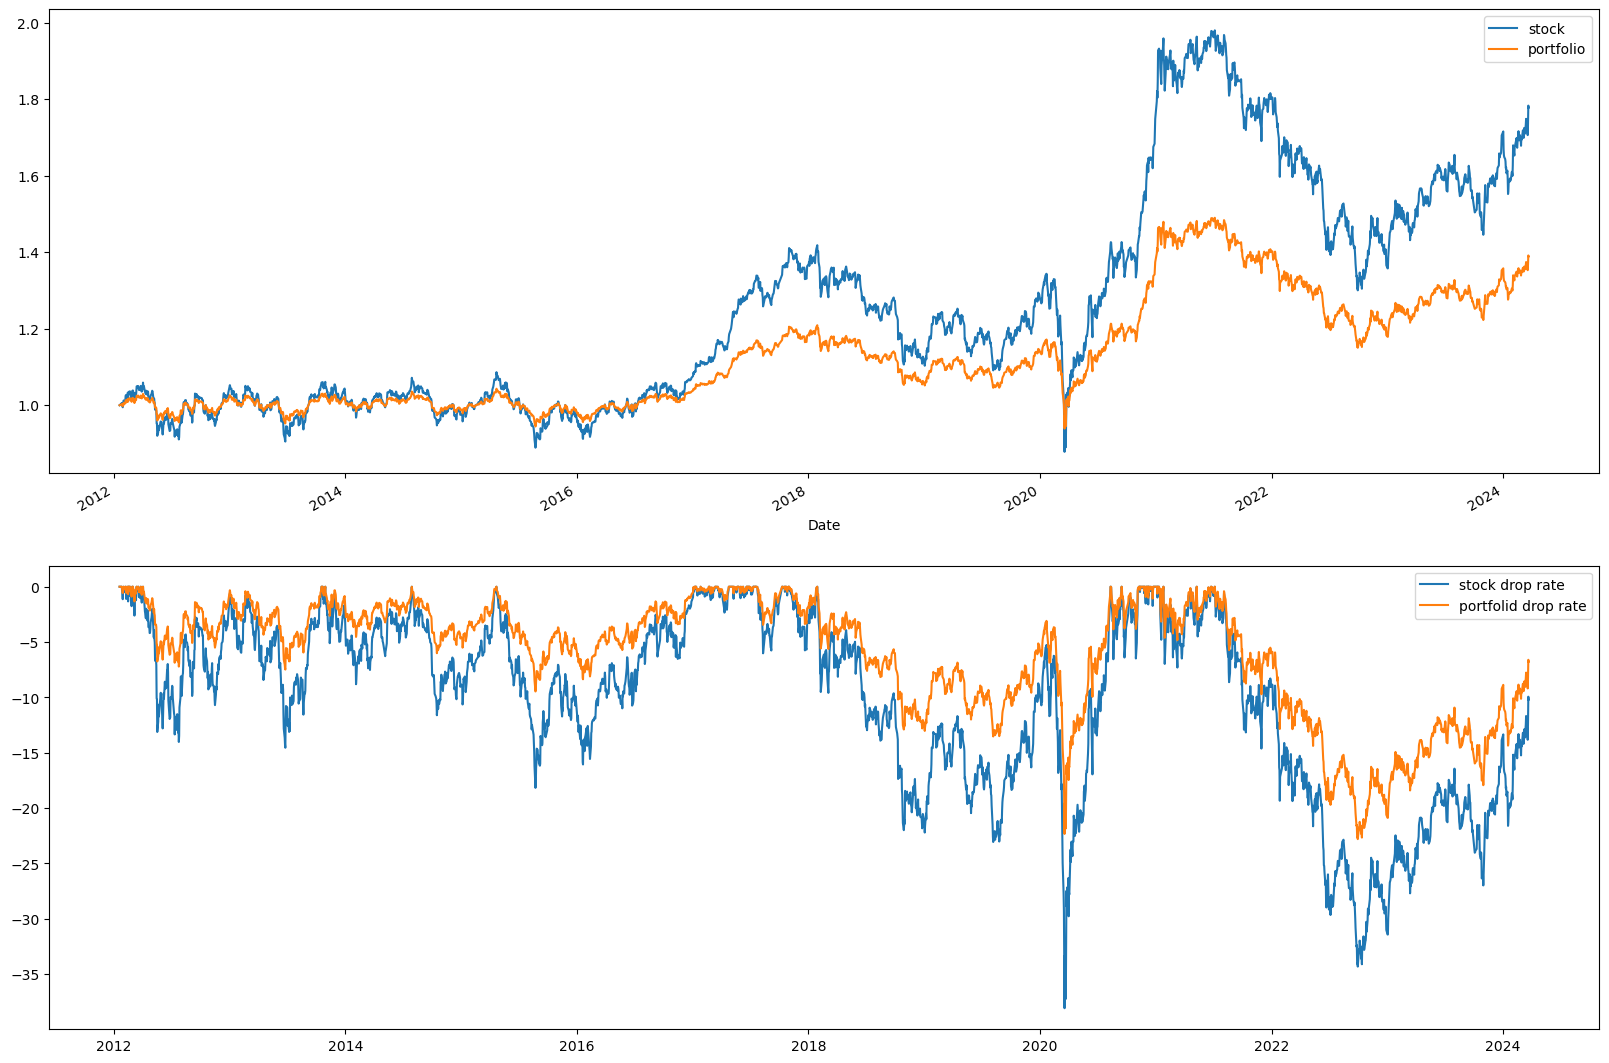

In [20]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn2.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd2 * -1, label="portfolid drop rate")
plt.legend()

plt.show()

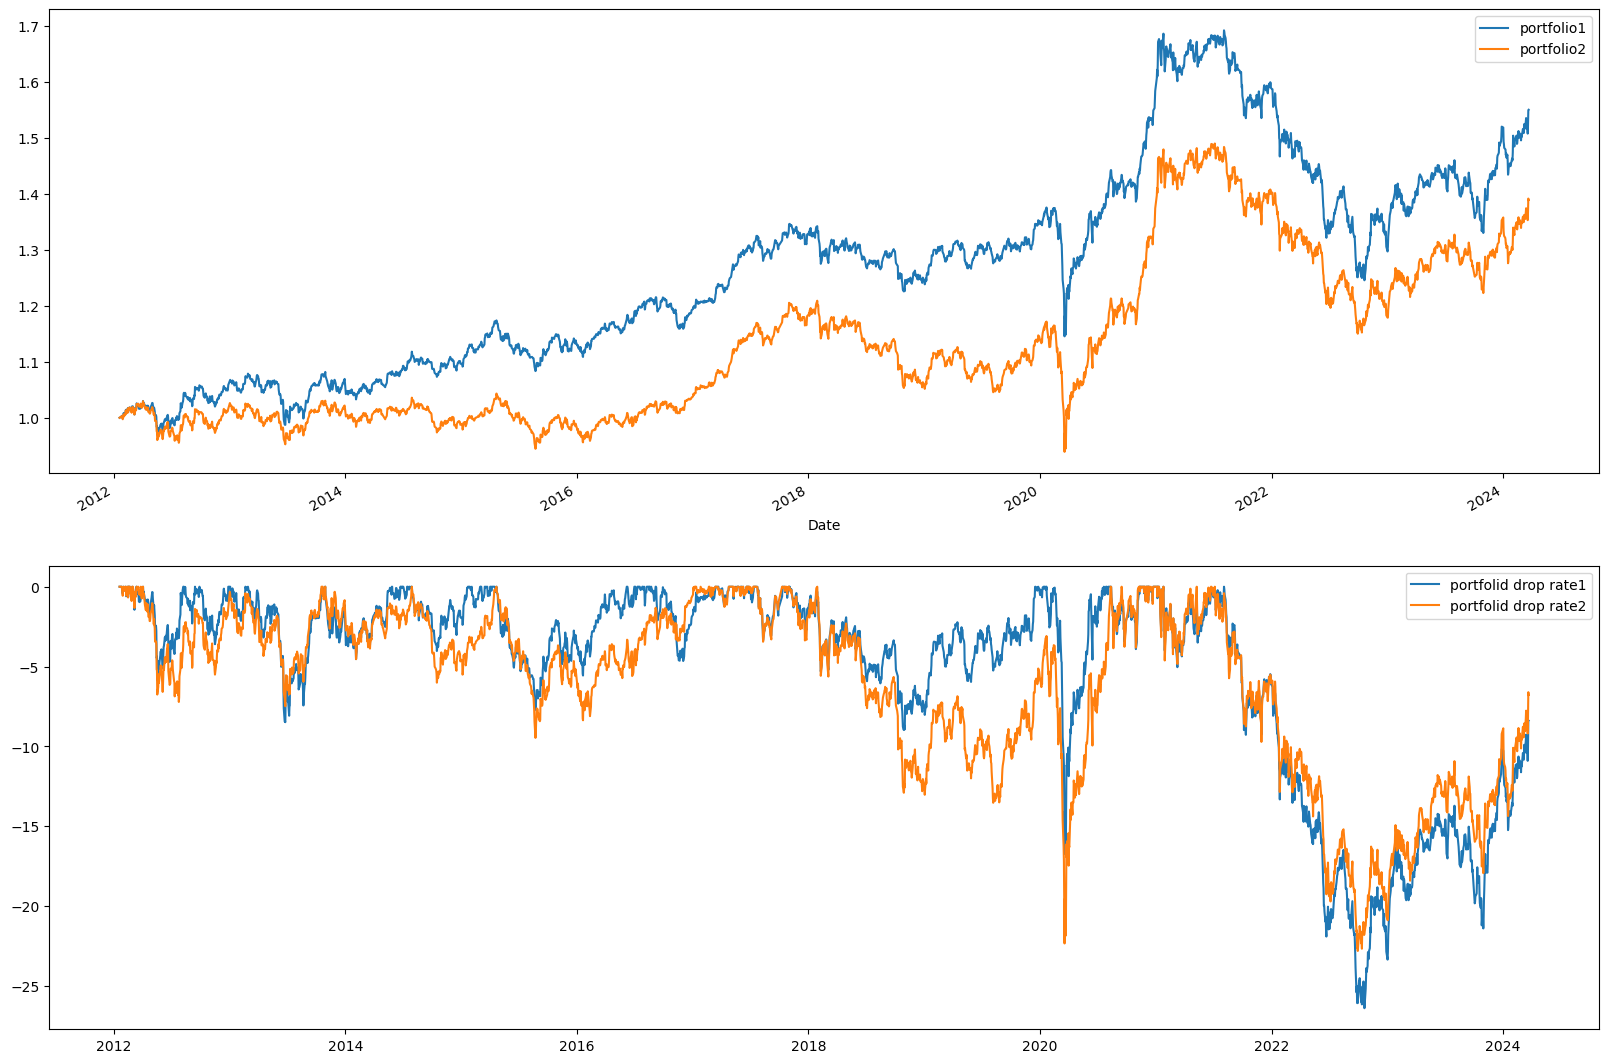

In [21]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
portCumReturn.plot(label="portfolio1")
portCumReturn2.plot(label="portfolio2")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(portDd * -1, label="portfolid drop rate1")
plt.plot(portDd2 * -1, label="portfolid drop rate2")
plt.legend()

plt.show()

## 단기채권

In [22]:
kodexShortBond = getCloseData("153130", "2012")
closeDataSet3 = pd.DataFrame(kodex200)
closeDataSet3.columns = ['kodex200']
closeDataSet3 = pd.concat([closeDataSet3, kodexShortBond], axis=1)
closeDataSet3.dropna(inplace=True)
closeDataSet3

,kodex200,Close
Date,,
2012-02-22,21914,87277.0
2012-02-23,21726,87299.0
2012-02-24,21819,87303.0
2012-02-27,21529,87308.0
2012-02-28,21696,87320.0
...,...,...
2024-03-18,36520,109035.0
2024-03-19,36085,109040.0
2024-03-20,36720,109045.0


In [23]:
portDayReturn3, portCumReturn3 = getPortfolioResult(closeDataSet3)
print("주식:단기채 1:1 혼합 포트폴리오 최종수익률")
print(portCumReturn3.iloc[-1])
portCagr3, portDd3, portMdd3 = getEvaluation(portCumReturn3)

주식:단기채 1:1 혼합 포트폴리오 최종수익률
1.4830919144685835
최종 수익률: 1.4830919144685835
cagr: 1.0339485825322623
mdd: 20.88718231727699


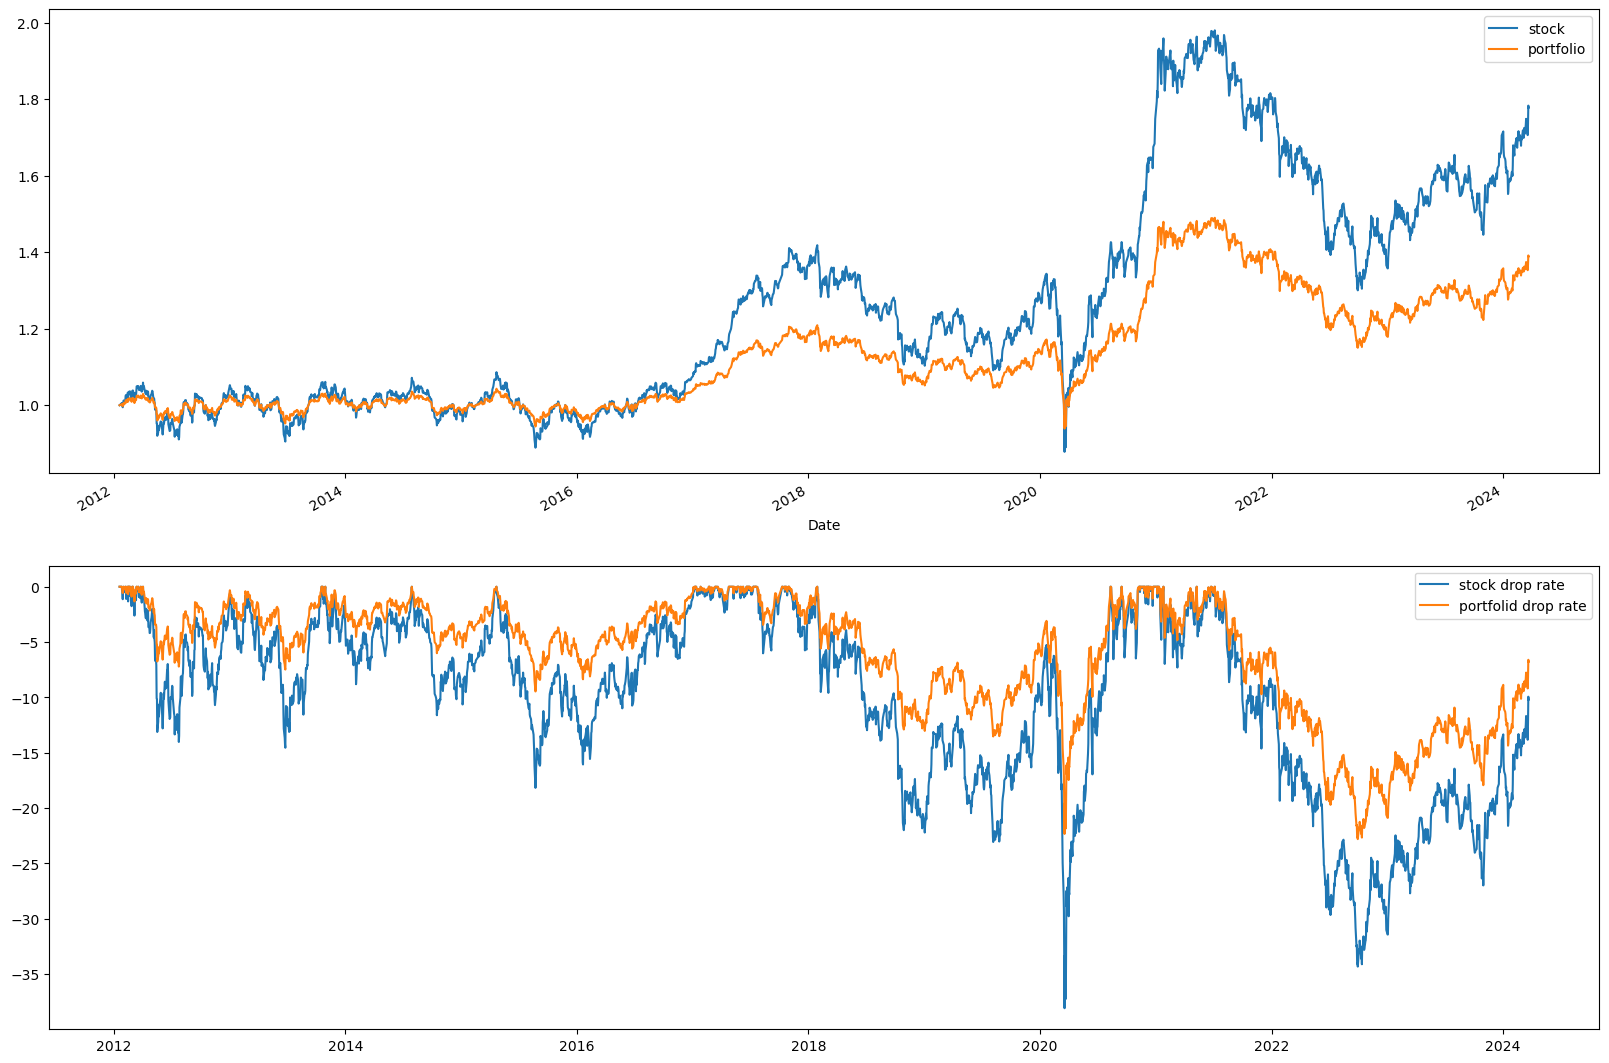

In [24]:
plt.figure(figsize=(20, 15))

# 수익곡선
plt.subplot(2,1,1)
kodex200CumReturn.plot(label="stock")
portCumReturn2.plot(label="portfolio")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(kodex200Dd * -1, label="stock drop rate")
plt.plot(portDd2 * -1, label="portfolid drop rate")
plt.legend()

plt.show()